# SVM Classification Using Individual Replicas
This notebook analyzes the quality of the classifiers resulting from training on individual replicas of read counts rather than averaged values. Data are adjusted for library size and gene length.

In [2]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [7]:
provider = DataProvider(is_normalize=False)
provider.do()
provider.dfs_centered_adjusted_read_count[1].head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Rv0001,702.025149,779.516150,1070.330107,521.248835,966.936447,484.195823,555.040510,831.962319,596.055777,436.412031,...,506.720680,1530.537317,4200.945280,907.661559,1659.302171,1416.808965,5445.610535,4040.124851,5459.701691,3478.791893
Rv0002,220.542687,269.453675,294.591012,153.028891,341.369245,149.461221,201.155532,327.676794,242.204515,179.118978,...,177.739408,256.130243,691.319398,396.455696,802.463710,660.245464,1097.233307,802.762651,1318.670928,1119.141608
Rv0003,148.669755,187.943639,190.481241,106.776727,205.851134,116.123453,120.865985,202.136128,239.309429,146.433324,...,170.142117,112.541873,314.458794,485.423051,983.433213,798.439168,482.854483,351.746580,675.442802,654.404557
Rv0004,64.976837,78.559085,65.477927,42.324591,71.765955,55.447652,42.010891,79.341913,83.944223,56.747405,...,64.590251,37.974005,134.469445,186.848768,264.589160,253.882070,231.471136,131.026697,285.204421,257.650020
Rv0005,2092.706817,2597.726971,3710.897521,1814.472108,3728.950511,1691.858454,2279.187143,3903.237362,1298.180611,1604.445036,...,607.371497,2610.424762,8464.092664,947.115256,1741.190571,1454.655816,6385.647779,5896.320893,10056.039420,9844.403232


In [2]:
data = TrinaryData()
data.df_X.head()
dd = DataProvider(is_normalize=False)
dd.do()

## Feature Selection
Determine how many features to include.

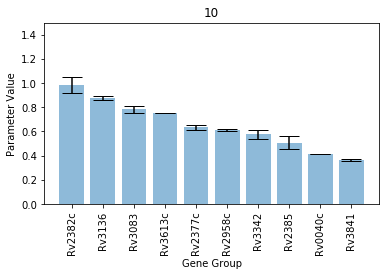

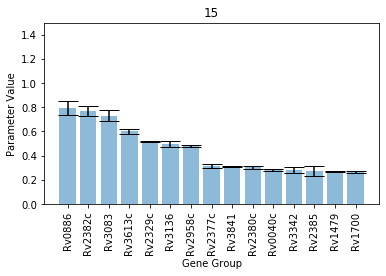

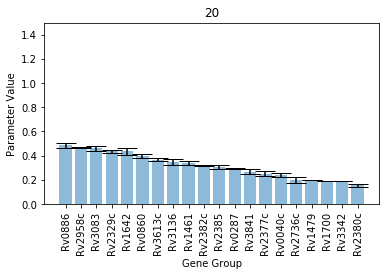

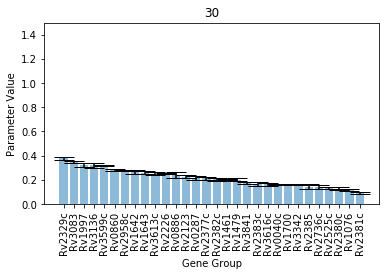

In [3]:
# Assess how many features should be included
for filter in [10, 15, 20, 30]:
    svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=filter, size=30)
    df_X = data.df_X.copy()
    df_X.columns = data.features
    svm_ensemble.fit(df_X, data.ser_y)
    # Analysis to determine how many features should be considered
    svm_ensemble.plotImportance(title="%d" % filter, ylim=[0, 1.5], ylabel="Parameter Value")
    #svm_ensemble.plotRank()